In [54]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from scipy import signal

from convnwb.io import make_session_name

from spiketools.spatial.information import compute_spatial_information
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot
from spiketools.plts.spatial import plot_heatmap, create_heatmap_title
from spiketools.plts.annotate import add_vlines, color_pvalue

from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates
from spiketools.utils.run import create_methods_list


In [55]:
import sys
sys.path.append('../code')
from models import create_df_place, fit_anova_place
from utils import  compute_firing_rates, compute_trial_firing_rates, compute_t_occupancy, circular_shuffle_unit_fr
sys.path.append('../scripts')
from settings import METHODS, SURROGATES

In [56]:

from scipy.io import loadmat
data = loadmat('/Users/weijiazhang/Data/Train/data_matfile/R1219C_0_train_events.mat')
behavioral_data = pd.read_csv('/Users/weijiazhang/Data/Train/events/events.csv')



## Settings

In [57]:
epochSize = 0.1
numBins = 40
kernelSize = 8
numBinsPos = 40
numBinsSpeed = 25

units = 19

In [58]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

In [59]:
# Get behavioral data
df = pd.DataFrame(data['events']['events'][0][0][0])
# Convert object columns to string type
str_cols = ['subj', 'object','timesfile']
for col in str_cols:
    df[col] = df[col].str[0].astype(str)
# Convert numeric columns to appropriate types
int_cols = ['session', 'trialNum', 'blockType', 'driveType'] 
float_cols = ['object_position', 'response_position', 'response_mstime', 'timesoffset','mstime', 'position','speed']
for col in int_cols:
    df[col] = df[col].str[0].astype(int)
for col in float_cols:
    df[col] = df[col].str[0].astype(float)

behavioral_data = df


In [60]:
events_fr = data['events']['fr'][0][0]
events_fr.shape

(7654, 23)

In [61]:
time_offset = df['timesoffset'][1]
time_offset

117022.44088541667

In [62]:
df

,subj,session,trialNum,blockType,driveType,object,object_position,response_position,response_mstime,wall_position,...,constant_speed,position,mstime,lfpfile,lfpmstime,lfpoffset,timesfile,timesoffset,eegoffset,eegfile
0,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.970167,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[233845]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.169224e+05,[[233845]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
1,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.835283,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234045]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.170224e+05,[[234045]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
2,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.584817,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234245]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.171224e+05,[[234245]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
3,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.217183,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234445]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.172224e+05,[[234445]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
4,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-32.736283,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234645]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.173224e+05,[[234645]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7649,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],29.248400,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568139]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284070e+06,[[4568139]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
7650,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],30.118150,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568339]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284170e+06,[[4568339]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
7651,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],30.887517,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568539]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284270e+06,[[4568539]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
7652,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],31.569600,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568739]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284370e+06,[[4568739]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...


## Extract Spikes

In [63]:

# Access spikeTimes from the nested structured array
spike_times = data['events']['spikeData'][0][0]['spikeTimes'][0][0][0][units]
print("Spike times shape:", spike_times.shape)
spike_times

Spike times shape: (1963, 1)


array([[9.72000000e+02],
       [5.03536667e+03],
       [6.39073333e+03],
       ...,
       [2.33852447e+06],
       [2.33940327e+06],
       [2.33970867e+06]])

In [64]:
# Get spike name and electrode labels
spike_name = data['events']['spikeData'][0][0]['spikeNames'][0][0][0][units]
print(f"Spike name: {spike_name}")

# Create DataFrame of electrode labels and clean up types
elec_labels = pd.DataFrame(data['events']['spikeData'][0][0]['elecLabels'][0][0][0])
elec_labels['ElectrodeID'] = elec_labels['ElectrodeID'].str[0].astype(int)
elec_labels['Label'] = elec_labels['Label'].str[0].astype(str)
elec_labels = elec_labels[elec_labels['Label'] != 'ainp1']

# Find matching electrode label
label = None
for idx, elec_id in enumerate(elec_labels['ElectrodeID'].values):
    if str(elec_id) in str(spike_name):
        label = elec_labels['Label'].iloc[idx]
        break

Spike name: ['NSX124_2']


In [65]:
speeds = np.array(behavioral_data['speed'])
bad = speeds < 2



In [66]:
# Get speeds and create mask for valid speeds (>= 2)
# speeds = np.array(behavioral_data['speed'])
# bad = speeds < 2
# Apply mask to events_fr, ensuring dimensions match
behavioral_data = behavioral_data[~bad]
events_fr = events_fr[~bad,:]

In [67]:
events_fr.shape

(6957, 23)

In [68]:
units_fr = events_fr[:,units]
len(events_fr[1])


23

## Extract Position Data 

In [69]:
positions = behavioral_data['position']
positions = (positions + 34) / 68  # Normalize to 0-1 range
positions[positions < 0] = 0  # Clip values below 0
positions[positions > 1] = 1 
positions 

1       0.002422
2       0.006106
3       0.011512
4       0.018584
5       0.027382
          ...   
7649    0.930124
7650    0.942914
7651    0.954228
7652    0.964259
7653    0.973158
Name: position, Length: 6957, dtype: float64

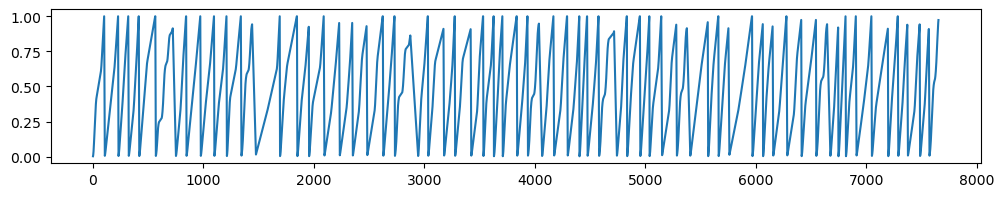

In [70]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
plt.plot(positions)

### Bin positions into percentage along the track

In [71]:
edges_pos = np.linspace(0, 100, numBinsPos+1)
pos_bin = np.digitize(positions*100, edges_pos)


count, _ = np.histogram(positions*100, bins=edges_pos)

## Occupancy

In [73]:
counts = count[:numBins]
occ = counts * epochSize
pos_bin.shape

(6957,)

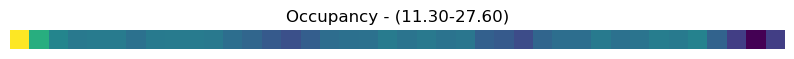

In [74]:
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ), figsize=(10, 6))

## Smoothing Kernel

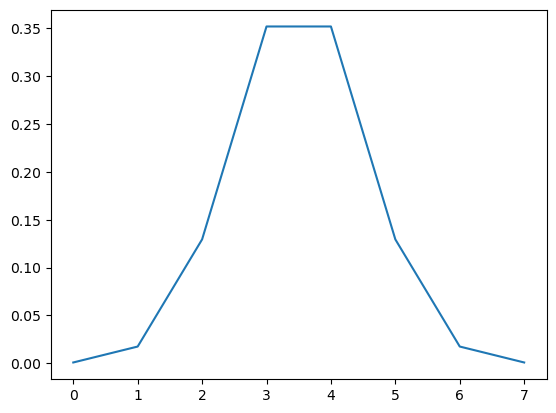

In [75]:
kernelSize = 8
g = signal.windows.gaussian(kernelSize, std=1)
g = g/np.sum(g)
plt.plot(g)

In [79]:
place_bins = compute_firing_rates(units_fr, pos_bin, occ, g, numBins, epochSize)

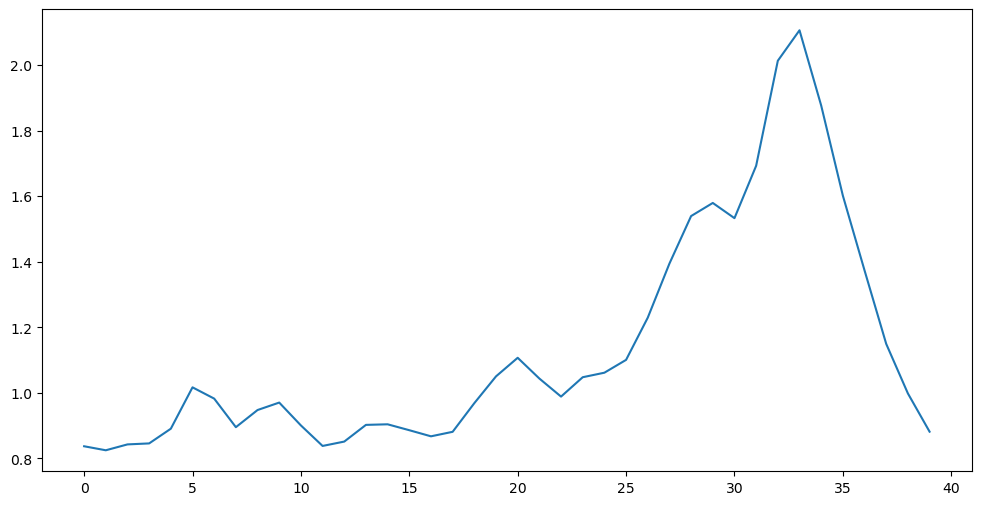

In [80]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.plot(place_bins)

## Compute Smoothed Firing Rates by Trial

In [81]:
# Bin by trial number
edges_trial = np.arange(0.5, 65, 1)  # 0.5:1:65 in MATLAB
trial_bin = np.array(behavioral_data['trialNum'])

In [82]:
behavioral_data

,subj,session,trialNum,blockType,driveType,object,object_position,response_position,response_mstime,wall_position,...,constant_speed,position,mstime,lfpfile,lfpmstime,lfpoffset,timesfile,timesoffset,eegoffset,eegfile
1,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.835283,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234045]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.170224e+05,[[234045]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
2,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.584817,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234245]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.171224e+05,[[234245]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
3,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-33.217183,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234445]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.172224e+05,[[234445]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
4,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-32.736283,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234645]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.173224e+05,[[234645]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
5,R1219C,0,1,1,0,barrel.egg,-19.2132,-25.80130,1.474039e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],-32.138033,1.474039e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[234845]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,1.174224e+05,[[234845]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7649,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],29.248400,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568139]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284070e+06,[[4568139]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
7650,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],30.118150,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568339]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284170e+06,[[4568339]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
7651,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],30.887517,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568539]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284270e+06,[[4568539]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...
7652,R1219C,0,64,2,1,desk.egg,-7.1393,-5.58005,1.474041e+12,"[[nan, nan, nan, nan, nan, nan]]",...,[[0]],31.569600,1.474041e+12,[/data10/RAM/subjects/R1219C/lfp.noreref/_2016...,[],[[4568739]],/data10/RAM/subjects/R1219C/npt/20160916-11053...,2.284370e+06,[[4568739]],[/Users/Salmonster/Volumes/rhino/data10/RAM/su...


## Compute Trial Occupancy

In [84]:
trial_occupancy = compute_t_occupancy(trial_bin, pos_bin, edges_trial, edges_pos, epochSize)

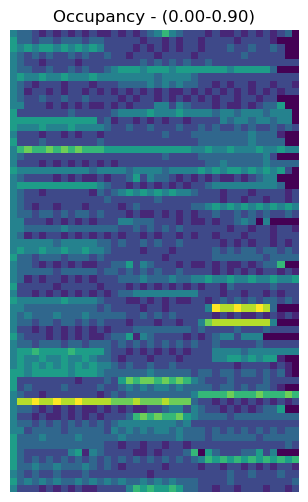

In [85]:
plot_heatmap(trial_occupancy, title= create_heatmap_title('Occupancy', trial_occupancy), figsize=(10, 6))

In [88]:
trial_place_bins, trial_fr = compute_trial_firing_rates(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)

/Users/weijiazhang/code/AnalyzeTrain/notebooks/../code/utils.py:148: RuntimeWarning: invalid value encountered in divide
  trial_fr = trial_spikes/trial_occupancy


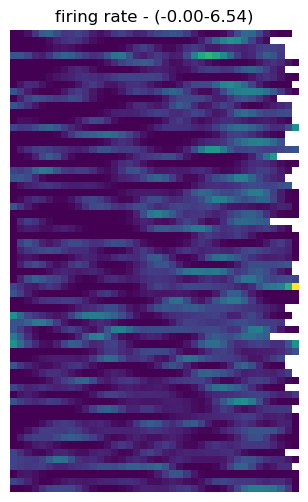

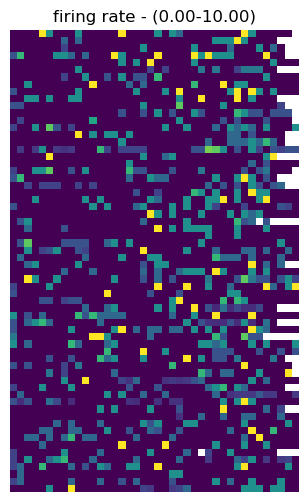

In [89]:
plot_heatmap(trial_place_bins, title= create_heatmap_title('firing rate', trial_place_bins[:,:-3]), figsize=(5, 6))
plot_heatmap(trial_fr, title= create_heatmap_title('firing rate', trial_fr[:,:-3]), figsize=(5, 6))

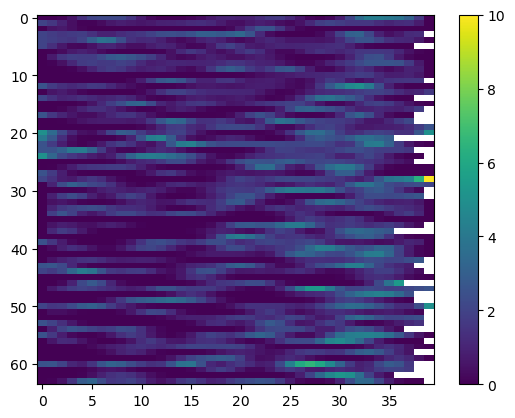

In [90]:
plt.imshow(trial_place_bins[:, :], aspect='auto')

plt.colorbar()
plt.show()

In [91]:
place_bins = np.nanmean(trial_place_bins,axis = 0)
place_sem = np.nanstd(trial_place_bins,axis = 0)/np.sqrt(trial_place_bins.shape[0])

s_bins = np.linspace(0, 40, numBinsPos+1)


In [92]:
fr_bins = np.nanmean(trial_fr,axis = 0)
fr_sem = np.nanstd(trial_fr,axis = 0)/np.sqrt(trial_fr.shape[0])


## Statistical Analysis

In [93]:
results = {}

### Spatial Information

In [94]:
# Compute mutual information of spiking and location
results['place_info'] = compute_spatial_information(place_bins, occ, normalize=False)
results['place_fr_info'] = compute_spatial_information(fr_bins, occ, normalize=False)
print(results['place_info'])
print(results['place_fr_info'])


0.06297535499833747
0.11090491084887405


### ANOVA

In [95]:
# Create the dataframe
df = create_df_place(trial_place_bins[:,:-3])
results['place_anova']= fit_anova_place(df)
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(results['place_anova']))

The ANOVA place F-value is 7.80


In [96]:
df_fr = create_df_place(trial_fr[:,:-3])
results['place_fr_anova']= fit_anova_place(df_fr)
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(results['place_fr_anova']))


The ANOVA place F-value is 3.06


In [97]:
# Shuffle settings
shuffle_approach = 'CIRCULAR' # 'ISI', 'BINCIRC'
n_surrogates =1000

In [98]:

shuffles = circular_shuffle_unit_fr(units_fr, n_surrogates)




In [99]:
METHODS

{'PLACE': ['ANOVA', 'INFO'], 'PLACE_FR': ['ANOVA', 'INFO']}

In [100]:
#METHODS = ['place_info','place_anova','place_info_fr','place_anova_fr']

In [101]:
surr_analyses = create_methods_list(METHODS)
surrs = {analysis : \
                    np.zeros(SURROGATES['n_shuffles']) for analysis in surr_analyses}


In [102]:
surrs.keys()

dict_keys(['place_anova', 'place_info', 'place_fr_anova', 'place_fr_info'])

In [103]:
for ind, shuffle in enumerate(shuffles):
    surr_place_bins = compute_firing_rates(shuffle, pos_bin, occ, g, numBins, epochSize)
    surr_trial_place_bins, surr_trial_fr = compute_trial_firing_rates(trial_bin, pos_bin, shuffle, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)
    surr_fr = np.nanmean(surr_trial_fr,axis = 0)
    #surr_place_bins= np.nanmean(surr_trial_place_bins,axis = 0)
    surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)
    surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_trial_place_bins))
    surrs['place_fr_info'][ind] = compute_spatial_information(surr_fr, occ, normalize=False)
    surrs['place_fr_anova'][ind] = fit_anova_place(create_df_place(surr_trial_fr))

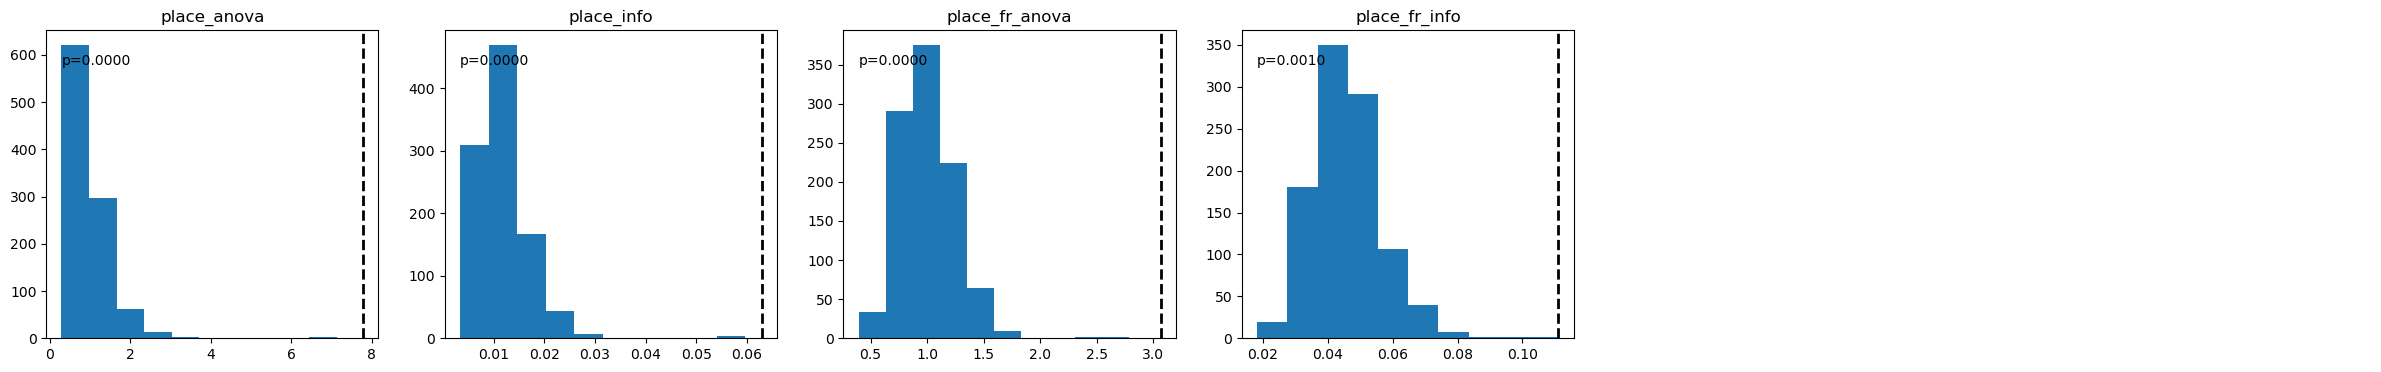

In [104]:
axes = make_axes(4, 6, figsize=(30, 4))
i = 0
for analysis in surr_analyses:
    results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
                        compute_surrogate_stats(results[analysis], surrs[analysis],title = analysis,plot = True, ax=axes[i])
    i = i+1


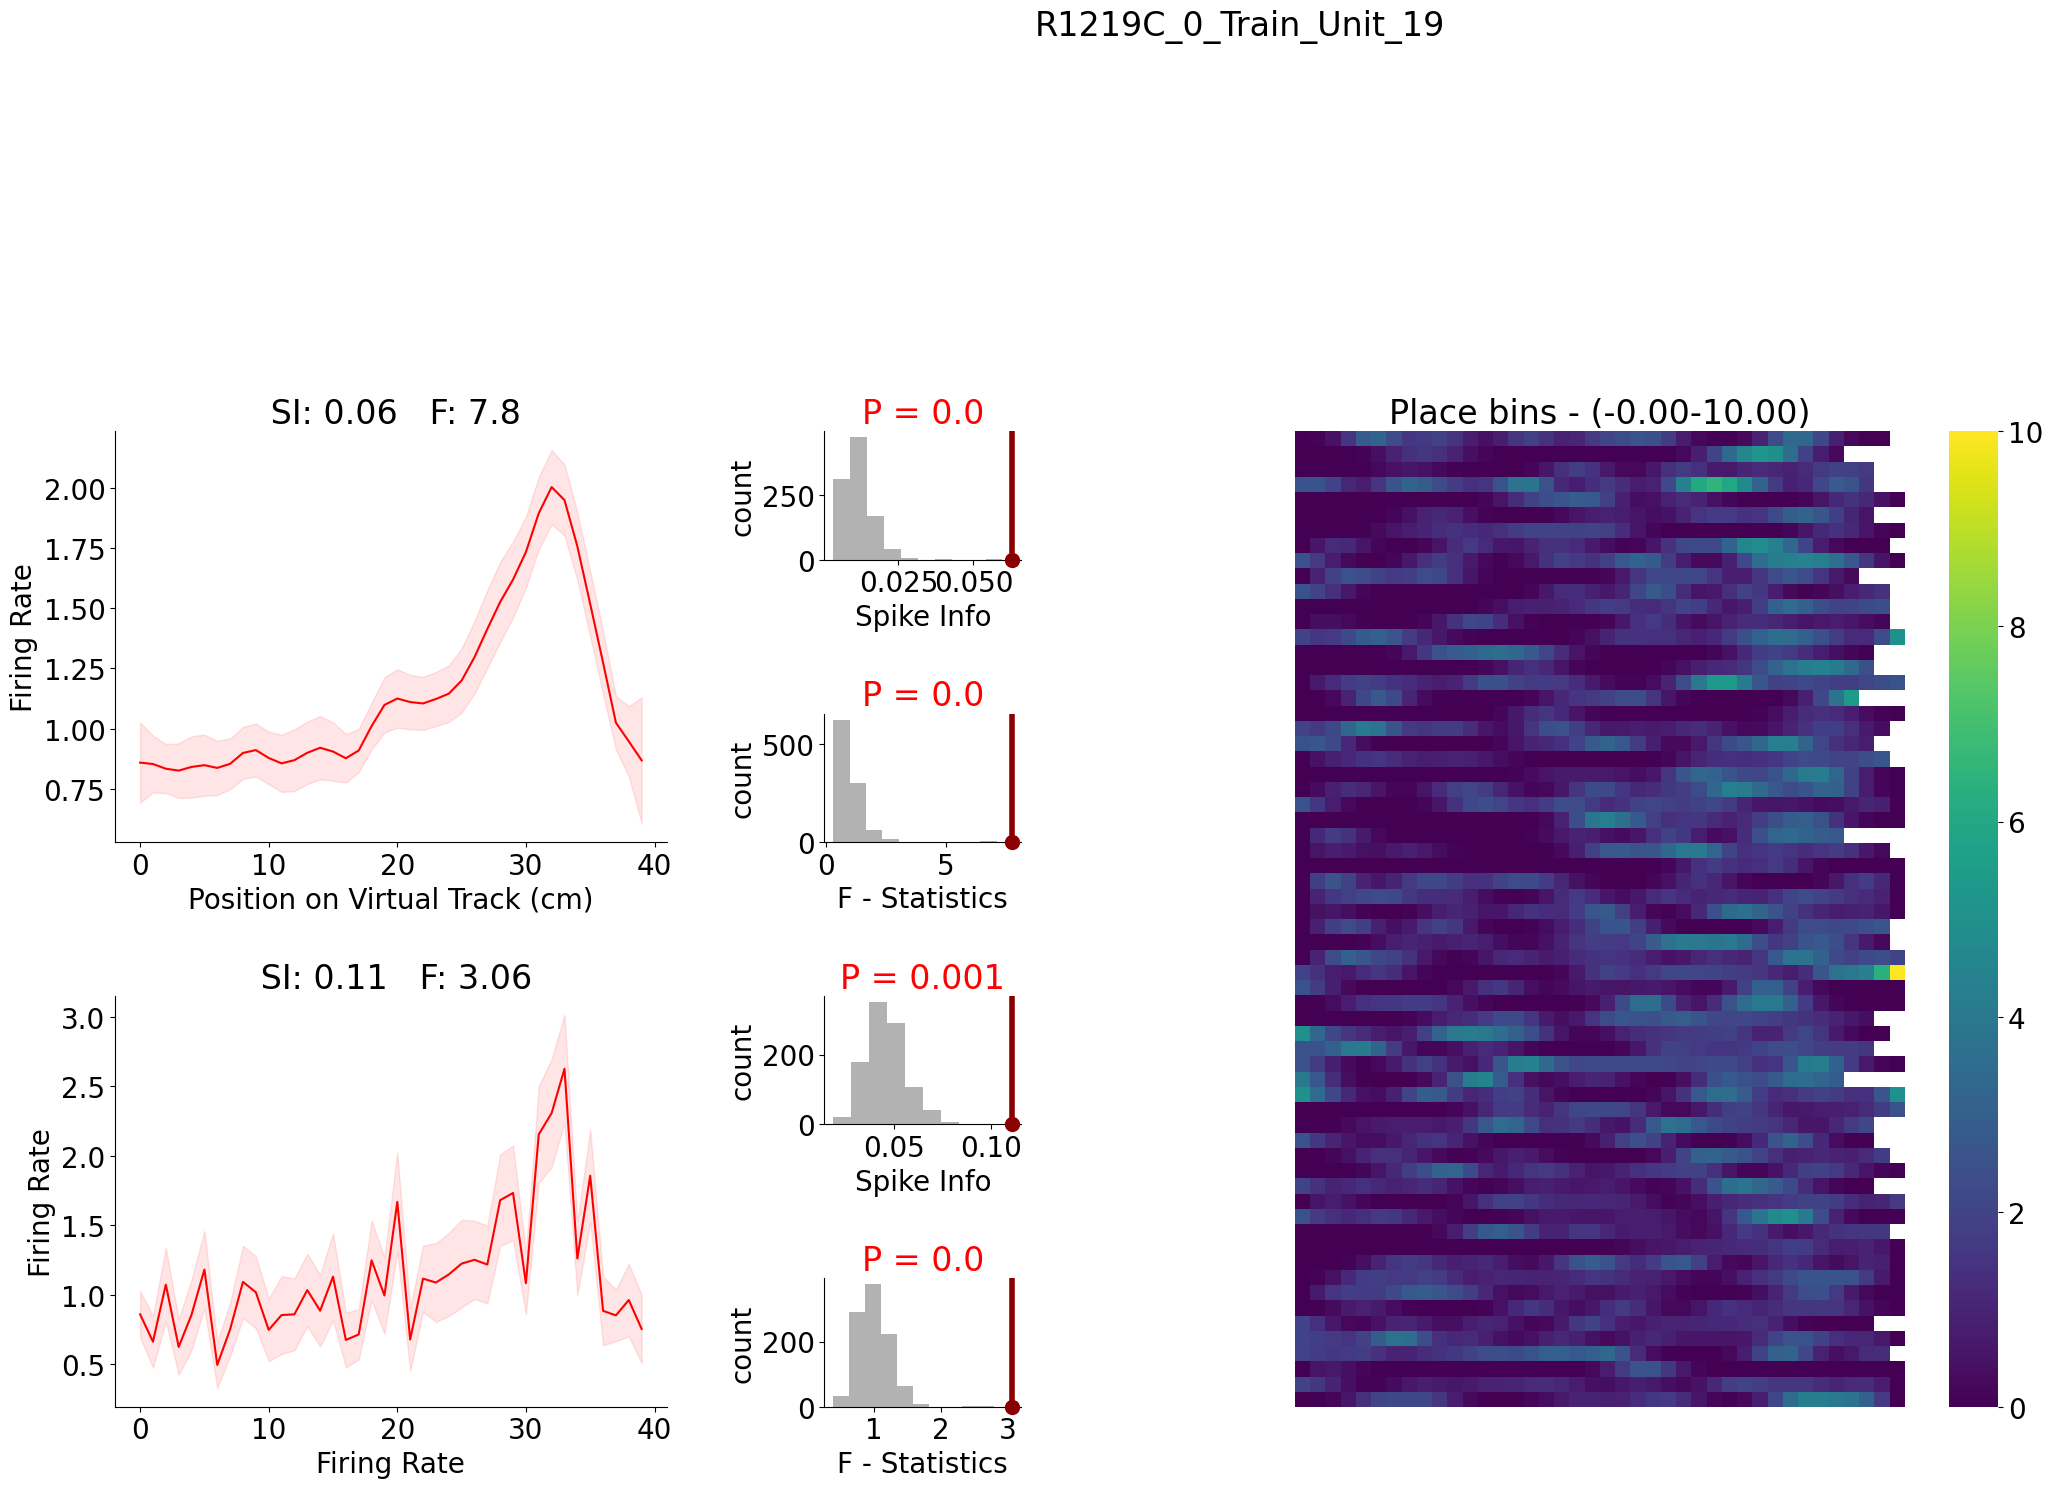

In [ ]:
plt.rcParams.update({'font.size': 20})
grid = make_grid(6, 7, wspace=.8, hspace=1.2, figsize=(30, 20)
                    ,title = 'R1219C_0_Train_Unit_19')

#plt.rcParams.update({'font.size': 25})
SI = results['place_info']
F = results['place_anova']
SI_fr = results['place_fr_info']
F_fr = results['place_fr_anova']

ax = get_grid_subplot(grid, slice(1,3), slice(0,2))
ax.plot( s_bins[:-1], place_bins, color = 'red', label='Mean Value')
ax.fill_between( s_bins[:-1], place_bins - place_sem, place_bins+ place_sem, color = 'red', alpha=0.1)
ax.set_xlabel('Position on Virtual Track (cm)')
ax.set_ylabel('Firing Rate')
ax.set_title(f' SI: {np.round(SI,2)}   F: {np.round(F,2)}')
drop_spines(['top','right'],ax = ax)

ax = get_grid_subplot(grid, slice(3,5), slice(0,2))
ax.plot( s_bins[:-1], fr_bins, color = 'red', label='Mean Value')
ax.fill_between( s_bins[:-1], fr_bins - fr_sem, fr_bins+ fr_sem, color = 'red', alpha=0.1)
ax.set_xlabel('Firing Rate')
ax.set_ylabel('Firing Rate')
ax.set_title(f' SI: {np.round(SI_fr,2)}   F: {np.round(F_fr,2)}')
drop_spines(['top','right'],ax = ax)

ax = get_grid_subplot(grid, 1, 2)
P = results['place_info_surr_p_val']
plot_surrogates(surrs['place_info'], data_value=SI, p_value=None, title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(SI , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(SI , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, 2, 2)
P = results['place_anova_surr_p_val']
plot_surrogates(surrs['place_anova'], data_value=F, p_value=None ,title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(F , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(F , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('F - Statistics')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)


ax = get_grid_subplot(grid, 3, 2)
P = results['place_fr_info_surr_p_val']
plot_surrogates(surrs['place_fr_info'], data_value=SI_fr, p_value=None, title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(SI_fr , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(SI_fr , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, 4, 2)
P = results['place_fr_anova_surr_p_val']
plot_surrogates(surrs['place_fr_anova'], data_value=F_fr, p_value=None ,title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(F_fr , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(F_fr , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('F - Statistics')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)


ax = get_grid_subplot(grid, slice(1,5), slice(3,6))
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), ax=ax)



